# DSCI 551 Project: File System & Analysis on COVID-19 Vaccination Rates
Gordon Su, Lucas Huang  
Section 32414 (Afternoon)

Date range: 2021-3-1 to 2022-03-29

### All necessary imports

In [348]:
import datetime
import firebase_admin
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests

from calendar import monthrange
from firebase_admin import db
from firebase_admin import credentials
from statsmodels.tsa.stattools import coint

### Import and preview vaccination data

In [299]:
vacc_df = pd.read_csv('./data/country_vaccinations.csv')
vacc_df['date'] = pd.to_datetime(vacc_df['date'])
vacc_df['year'] = vacc_df.apply(lambda row: row.date.year, axis=1)
vacc_df['month'] = vacc_df.apply(lambda row: row.date.month, axis=1)
vacc_df['day'] = vacc_df.apply(lambda row: row.date.day, axis=1)

vacc_cols_to_drop = ['date', 'iso_code', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 
                'daily_vaccinations', 'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 
                'people_fully_vaccinated_per_hundred', 'daily_vaccinations_per_million', 'vaccines', 
                'source_name', 'source_website']
vacc_df = vacc_df.drop(vacc_cols_to_drop, axis=1)
vacc_df.head(3)

,country,daily_vaccinations_raw,year,month,day
0,Afghanistan,NaN,2021,2,22
1,Afghanistan,NaN,2021,2,23
2,Afghanistan,NaN,2021,2,24


### Import and preview PFE price data

In [300]:
pfe_prices_df = pd.read_csv('./data/PFE_historical_prices.csv')
pfe_prices_df['Date'] = pd.to_datetime(pfe_prices_df['Date'])
pfe_prices_df['year'] = pfe_prices_df.apply(lambda row: row.Date.year, axis=1)
pfe_prices_df['month'] = pfe_prices_df.apply(lambda row: row.Date.month, axis=1)
pfe_prices_df['day'] = pfe_prices_df.apply(lambda row: row.Date.day, axis=1)

pfe_cols_to_drop = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
pfe_prices_df = pfe_prices_df.drop(pfe_cols_to_drop, axis=1)
pfe_prices_df.head(3)

,Adj Close,year,month,day
0,38.354626,2020,12,2
1,37.687180,2020,12,3
2,37.922195,2020,12,4


### Convert vaccination dataframe into json format

In [302]:
selected_countries = ['Australia', 'Belgium', 'Canada', 'France', 'Germany', 'Italy', 'Japan', 'Switzerland', 'United Kingdom', 'United States']
selected_countries_json_files = []
all_years = [2020, 2021, 2022]
all_months = [month for month in range(1, 13)]

for country in selected_countries:
    country_df = vacc_df.loc[vacc_df['country'] == country]
    country_dict = {}
    
    for year in all_years:
        year_df = country_df.loc[country_df['year'] == year]
        year_dict = {}
        
        for month in all_months:
            month_df = year_df.loc[year_df['month'] == month]
            
            if len(month_df) > 0:
                month_dict = dict(month_df[['day', 'daily_vaccinations_raw']].values)
                month_dict = {int(k):(0 if math.isnan(v) else int(v)) for k,v in month_dict.items()}

                year_dict[month] = month_dict
        country_dict[year] = year_dict
    
    file_name = './data/' + country + '_vaccinations.json'
    selected_countries_json_files.append(country + '_vaccinations.json')
    
    with open(file_name, 'w') as json_file:
        json.dump(country_dict, json_file)

### Convert PFE dataframe into json format

In [303]:
all_years = [2020, 2021, 2022]
all_months = [month for month in range(1, 13)]

pfe_dict = {}
    
for year in all_years:
    year_df = pfe_prices_df.loc[pfe_prices_df['year'] == year]
    year_dict = {}

    for month in all_months:
        month_df = year_df.loc[year_df['month'] == month]
        
        if len(month_df) > 0:
            month_dict = dict(month_df[['day', 'Adj Close']].values)
            month_dict = {int(k):(0 if math.isnan(v) else float(v)) for k,v in month_dict.items()}

            year_dict[month] = month_dict
    pfe_dict[year] = year_dict

pfe_file_name = './data/PFE_historical_prices.json'

with open(pfe_file_name, 'w') as json_file:
    json.dump(pfe_dict, json_file)

### EDFS Implementation

In [ ]:
cred = credentials.Certificate('./dsci-551-3cb2b-firebase-adminsdk-7ajia-c0dffd1d3c.json')
databaseURL = 'https://dsci-551-3cb2b-default-rtdb.firebaseio.com/'
default_app = firebase_admin.initialize_app(cred, {
    'databaseURL': databaseURL
})
ref = db.reference('/')

In [476]:
# help
def edfs_help():
    print('''\033[1m\033[4mFunctions:\033[0m\033[0m
    \033[1mremove_file(path)\033[0m \t\t\t Usage example: remove_file('/test/test.json')
    \033[1mremove_directory(path)\033[0m \t\t Usage example: remove_directory('/test/')
    \033[1mcat_file(path)\033[0m \t\t\t Usage example: cat_file('/test/test.json')
    \033[1mlist_contents(path)\033[0m \t\t Usage example: list_contents('/test/')
    \033[1mmake_directory(path)\033[0m \t\t Usage example: make_directory('/test/')
    \033[1mput_file(file, path)\033[0m \t\t Usage example: put_file('test.json', '/test/')
    \033[1mgetPartitionLocations(file_path)\033[0m \t\t Usage example: getPartitionLocations('/test/test.json')
    \033[1mreadPartition(file_path, partition_num)\033[0m \t\t Usage example: readPartition('/test/test.json', 1)''')

# rm
def remove_file(path):
    splitPath = os.path.splitext(path)
    
    # Remove file metadata
    metadata_ref = db.reference(splitPath[0] + splitPath[1].replace('.', ' '))
    children = metadata_ref.get()
    if children == None:
        print('File does not exist')
        return
    for key, value in children.items():
        metadata_ref.child(key).set({})
        
    # Remove file partition contents
    partition_contents_ref = db.reference('/partitions' + splitPath[0] + splitPath[1].replace('.', ' '))
    children = partition_contents_ref.get()
    if children != None:
        for key, value in children.items():
            partition_contents_ref.child(key).set({})
    
    parent_dir_path = path[:path.rfind('/')]
    
    # Parent directory is now empty
    metadata_parent_ref = db.reference(parent_dir_path)
    children = metadata_parent_ref.get()
    if children == None:
        print('Directory empty')
        
        # Set new path for metadata
        metadata_parent_ref.set({
            'New Path':
            {
                'New_Path': True
            }})

        # Set new path for partition contents
        partition_contents_parent_ref = db.reference('/partitions' + parent_dir_path)
        partition_contents_parent_ref.set({
            'New Path':
            {
                'New_Path': True
            }})
        
# rm directory
def remove_directory(path):
    # Remove metadata directory
    metadata_ref = db.reference(path)
    children = metadata_ref.get()
    if children == None:
        print('Directory does not exist')
        return
    for key, value in children.items():
        metadata_ref.child(key).set({})
        
    # Remove partition contents directory
    partition_contents_ref = db.reference('/partitions' + path)
    children = partition_contents_ref.get()
    if children != None:
        for key, value in children.items():
            partition_contents_ref.child(key).set({})

# cat
def cat_file(path):
    splitPath = os.path.splitext(path)
    metadata_ref = db.reference(splitPath[0] + splitPath[1].replace('.', ' '))
    contents = metadata_ref.get()
    if contents == None:
        print('File does not exist')
        return
    for key, value in contents.items():
        if 'location' in value:
            partition_ref = db.reference(value['location'])
            partition_contents = partition_ref.get()
            print(json.dumps(partition_contents, indent=1))

# ls
def list_contents(path):
    ref = db.reference(path)
    contents = ref.get()
    if contents == None:
        print('Directory does not exist')
        return
    for key, val in contents.items():
        print(key.replace(' ', '.'))   
        
# mkdir
def make_directory(path):
    # Set new path for metadata
    metadata_ref = db.reference(path)
    metadata_ref.set({
        'New Path':
        {
            'New_Path': True
        }})
    
    # Set new path for partition contents
    partition_contents_ref = db.reference('/partitions' + path)
    partition_contents_ref.set({
        'New Path':
        {
            'New_Path': True
        }})
    
# put
def put_file(file, path):
    dir_ref = db.reference(path)
    query = dir_ref.child('New Path').get()
    if query != None:
        dir_ref.child('New Path').set({})
        
    name_of_file = file.replace('.', ' ')
    file_ref = db.reference(path + name_of_file)
    
    dir_partition_contents_ref = db.reference('/partitions' + path)
    query = dir_partition_contents_ref.child('New Path').get()
    if query != None:
        dir_partition_contents_ref.child('New Path').set({})
        
    with open('./data/' + file, 'r') as f:
        contents = json.load(f)
        contents_df = pd.DataFrame(contents.items())
        partition_metadata = {}
        partition_num = 1
        
        for index, row in contents_df.iterrows():
            year = int(row[0])
            year_data = row[1]
            months = list(year_data.keys())
            months = [int(m) for m in months]
            months.sort()
            
            for month in months:
                partition_name = 'p' + str(partition_num)
                partition_path = '/partitions' + path + name_of_file + '/' + partition_name
                partition_ref = db.reference(partition_path)
                partition_dict = {}
                partition_num += 1
                
                # Store metadata
                metadata = {}
                metadata['location'] = partition_path
                metadata['year'] = year
                metadata['month'] = month
                partition_metadata[partition_name] = metadata
                
                # Store actual contents in partition
                for day, value in year_data[str(month)].items():
                    partition_dict[day] = value
                partition_ref.set(partition_dict)
                
        partition_metadata['metadata'] = {'num_partitions': partition_num - 1}
        file_ref.set(partition_metadata)
        
# getPartitionLocations (for PMR)
def getPartitionData(file_path):
    partition_data = []
    splitPath = os.path.splitext(file_path)
    
    metadata_ref = db.reference(splitPath[0] + splitPath[1].replace('.', ' '))
    partition_metadata = metadata_ref.get()
    num_partitions = partition_metadata['metadata']['num_partitions']
    
    for partition_num in range(1, num_partitions + 1):
        partition_name = 'p' + str(partition_num)
        location = partition_metadata[partition_name]['location']
        year = partition_metadata[partition_name]['year']
        month = partition_metadata[partition_name]['month']
        partition_data.append([location, year, month])
        
    return partition_data
    
# readPartition (for PMR)
def readPartition(partition_content_path):
    partition_content_ref = db.reference(partition_content_path)
    content = partition_content_ref.get()
    content_df = pd.DataFrame(content)
    
    metadata_path = partition_content_path[11:partition_content_path.rfind('/')]
    metadata_ref = db.reference(metadata_path)
    partition_metadata = metadata_ref.get()
    partition_name = partition_content_path[(partition_content_path.rfind('/') + 1):] 
    year = partition_metadata[partition_name]['year']
    month = partition_metadata[partition_name]['month']
    num_days_in_month = monthrange(year, month)[1]
    
    # Ensure correct number of days for each month
    if num_days_in_month > len(content_df):
        content_df = content_df.reindex(range(1, num_days_in_month + 1))
    elif num_days_in_month < len(content_df):
        content_df = content_df.iloc[:num_days_in_month]
    
    content_df = content_df.fillna(method='ffill')
    content_df = content_df.fillna(method='bfill') 
    return content_df.iloc[1:]

### Partition-based map and reduce (PMR) implementation

In [252]:
# Returns dataframe of all data within data range
# Returns -1 if no data within given range
def mapPartition(partition_content_path, partition_year, partition_month, start_date, end_date):
    partition_date = datetime.datetime(partition_year, partition_month, 1)
    start_year = start_date.year
    start_month = start_date.month
    start_day = start_date.day
    end_year = end_date.year
    end_month = end_date.month
    end_day = end_date.day
    
    partition_results = -1
    
    # Partition stores data for first month in date range
    if (partition_year == start_year) and (partition_month == start_month):
        partition_results = readPartition(partition_content_path)
        partition_results = partition_results.iloc[start_day - 1:]
    
    # Partition stores data for last month in date range
    elif (partition_year == end_year) and (partition_month == end_month):
        partition_results = readPartition(partition_content_path)
        partition_results = partition_results.iloc[:end_day]
        
    # Partition stores data for middle month in date range
    elif (partition_date > start_date) and (partition_date < end_date):
        partition_results = readPartition(partition_content_path)
    
    return partition_results
    
# Joins and returns all dataframes
# Returns -1 if no valid data
def reduce(all_partition_results):
    reduced_df = -1
    
    for partition_df in all_partition_results:
        if isinstance(partition_df, pd.DataFrame) and len(partition_df) > 0:
            if not isinstance(reduced_df, pd.DataFrame):
                reduced_df = partition_df
            else:
                reduced_df = pd.concat([reduced_df, partition_df])
    return reduced_df

# Returns dataframe of all data in data range
# Returns -1 if no results found
def pmf(file_path, start_date, end_date):
    all_partitions_data = getPartitionData(file_path)
    all_partition_results = []
    
    for partition_data in all_partitions_data:
        location = partition_data[0]
        year = int(partition_data[1])
        month = int(partition_data[2])
        partition_results = mapPartition(location, year, month, start_date, end_date)
        all_partition_results.append(partition_results)
        
    return reduce(all_partition_results)

### App analytics implementation

In [453]:
def app_explain():
    print('''\033[1m\033[4mApp Guide:\033[0m\033[0m
    \033[1mAnalysis Parameters:\033[0m
    country options: Australia, Belgium, Canada, France, Germany, Italy, Japan, Switzerland, United Kingdom, United States
    country = "_name_of_country_"
    start_date = datetime.datetime(year, month, day)
    end_date = datetime.datetime(year, month, day)
    \n
    \033[1mParameter Example:\033[0m
    country = "Germany"
    start_date = datetime.datetime(2021, 1, 1)
    end_date = datetime.datetime(2022, 3, 29)
    \n
    \033[1mFunctions:\033[0m
    \033[1mvisualize_data(country, start_date, end_date)\033[0m \t\t Description: Plots vaccination rates in desired country against PFE stock prices
    \033[1mcointegration_value(country, start_date, end_date)\033[0m \t\t Description: Measure cointegration of vaccination rates in desired country and PFE stock prices''')

def visualize_data(country, start_date, end_date):
    price_results = pmf('/PFE_data/PFE_historical_prices.json', start_date, end_date)
    vaccination_results = pmf('/country_vacc_data/' + country + "_vaccinations.json", start_date, end_date)
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(range(len(price_results)), np.array(price_results), 'r', label="Pfizer Stock Price")
    ax2.plot(range(len(vaccination_results)), np.array(vaccination_results), 'b', label="Daily Vaccinations in " + country)
    ax1.set_xlabel("Days since " + str(start_date))
    ax1.set_ylabel("Stock Price", color='r')
    ax2.set_ylabel("Daily Vaccinations", color='b')
    fig.legend(loc=(0,0))
    plt.show()
    
def cointegration_value(country, start_date, end_date):
    price_results = pmf('/PFE_data/PFE_historical_prices.json', start_date, end_date)
    vaccination_results = pmf('/country_vacc_data/' + country + "_vaccinations.json", start_date, end_date)
    stat_, pvalue_, crit_ = coint(np.array(price_results), np.array(vaccination_results))
    print(country + " Daily Vaccinations Cointegration Probability with Pfizer Stock Price:")
    print(str(pvalue_))
    return pvalue_

### Demonstrate EDFS functionality

In [ ]:
edfs_help()

In [ ]:
make_directory('/PFE_data/')

In [416]:
put_file('PFE_historical_prices.json', '/PFE_data/')

In [ ]:
make_directory('/country_vacc_data/')

In [417]:
for country_vacc_file in selected_countries_json_files:
    put_file(country_vacc_file, '/country_vacc_data/')

In [459]:
make_directory('/dummy/')

In [460]:
put_file('dummy.json', '/dummy/')

In [455]:
list_contents('/country_vacc_data/')

Australia_vaccinations.json
Belgium_vaccinations.json
Canada_vaccinations.json
France_vaccinations.json
Germany_vaccinations.json
Italy_vaccinations.json
Japan_vaccinations.json
Switzerland_vaccinations.json
United.Kingdom_vaccinations.json
United.States_vaccinations.json


In [461]:
cat_file('/dummy/dummy.json')

[
 null,
 123,
 234
]


## App: COVID-19 and PFE Stock Analysis

In [462]:
app_explain()

App Guide:
    Analysis Parameters:
    country options: Australia, Belgium, Canada, France, Germany, Italy, Japan, Switzerland, United Kingdom, United States
    country = "_name_of_country_"
    start_date = datetime.datetime(year, month, day)
    end_date = datetime.datetime(year, month, day)
    

    Parameter Example:
    country = "Germany"
    start_date = datetime.datetime(2021, 1, 1)
    end_date = datetime.datetime(2022, 3, 29)
    

    Functions:
    visualize_data(country, start_date, end_date) 		 Description: Plots vaccination rates in desired country against PFE stock prices
    cointegration_value(country, start_date, end_date) 		 Description: Measure cointegration of vaccination rates in desired country and PFE stock prices


In [474]:
country = 'France'
start_date = datetime.datetime(2021, 3, 1)
end_date = datetime.datetime(2022, 3, 29)

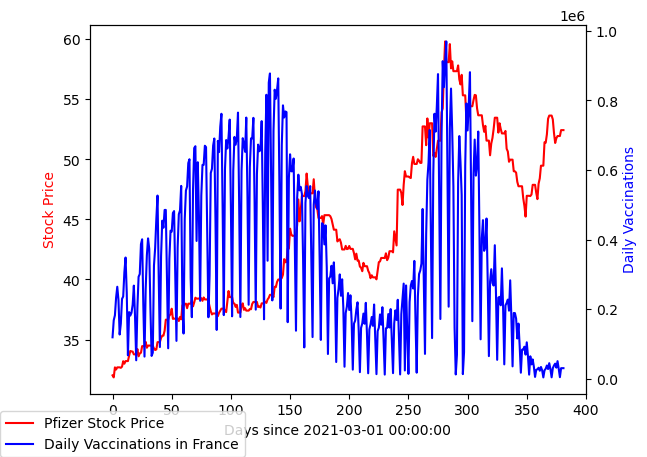

In [477]:
visualize_data(country, start_date, end_date)

In [479]:
cointegration_value(country, start_date, end_date)

France Daily Vaccinations Cointegration Probability with Pfizer Stock Price:
0.7649596606458102


In [478]:
for selected_country in selected_countries:
    cointegration_value(selected_country, start_date, end_date)

Australia Daily Vaccinations Cointegration Probability with Pfizer Stock Price:
0.839305912499262
Belgium Daily Vaccinations Cointegration Probability with Pfizer Stock Price:
0.7910094445244797
Canada Daily Vaccinations Cointegration Probability with Pfizer Stock Price:
0.7161795131169395
France Daily Vaccinations Cointegration Probability with Pfizer Stock Price:
0.7649596606458102
Germany Daily Vaccinations Cointegration Probability with Pfizer Stock Price:
0.8173510352628969
Italy Daily Vaccinations Cointegration Probability with Pfizer Stock Price:
0.8214487269767858
Japan Daily Vaccinations Cointegration Probability with Pfizer Stock Price:
0.7721488097658789
Switzerland Daily Vaccinations Cointegration Probability with Pfizer Stock Price:
0.7024968162016005
United Kingdom Daily Vaccinations Cointegration Probability with Pfizer Stock Price:
0.6995069173396222
United States Daily Vaccinations Cointegration Probability with Pfizer Stock Price:
0.6002137477465785
